# 한계점(데이터 추가 부분)

기존의 attribute가 상당수 삭제 됨에 따라 추가적인 attribute을 추가하기로 결정
지하철의 거리, 학교와의 거리, 공공도서관의 거리가 집값에 있어 상당한 영향을 미칠 것 이라고 생각, 이를 attribute에 추가

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from xgboost import XGBClassifier, plot_importance as xg_importance
#from lightgbm import LGBMClassifier, plot_importance as lgb_importance
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

from scipy.stats import norm
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import font_manager, rc
plt.rcParams["axes.unicode_minus"] = False
path = "C:/Windows/Fonts/H2GTRM.TTF"
font_name = font_manager.FontProperties(fname=path).get_name()
rc("font", family=font_name)
import matplotlib.font_manager as fm
plt.rcParams['font.family'] = 'Malgun Gothic'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [10]:
df = pd.read_csv("2019년도 중복제거 실거래 데이터.csv", encoding='cp949')
df_tg = df[["물건금액(만원)","자치구코드", "자치구명", "법정동코드", "법정동명", "건물명", "k-아파트코드", "좌표X",
              "좌표Y", 'k-전체동수', 'k-연면적', '건물면적(㎡)', "층"]]
df_tg1 = df_tg.drop_duplicates()
##pip install havesine
from haversine import haversine
df_tg2 = df_tg1[["좌표X", "좌표Y"]]

In [11]:
df_tg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12092 entries, 0 to 12091
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   물건금액(만원)  12092 non-null  int64  
 1   자치구코드     12092 non-null  int64  
 2   자치구명      12092 non-null  object 
 3   법정동코드     12092 non-null  int64  
 4   법정동명      12092 non-null  object 
 5   건물명       12092 non-null  object 
 6   k-아파트코드   12092 non-null  object 
 7   좌표X       12090 non-null  float64
 8   좌표Y       12090 non-null  float64
 9   k-전체동수    12002 non-null  float64
 10  k-연면적     12092 non-null  float64
 11  건물면적(㎡)   12092 non-null  float64
 12  층         12092 non-null  float64
dtypes: float64(6), int64(3), object(4)
memory usage: 1.2+ MB


In [12]:
df_tg2["지하철_거리(km)"] = np.nan
df_tg2["지하철역_개수"] = np.nan
df_tg2 =df_tg2.drop_duplicates()
sub_loc = pd.read_excel("지하철노선위경도정보.xlsx")
sub_loc = sub_loc[(sub_loc['역지역'] == "수도권" )]

dis = []
for index, i in df_tg2.iterrows():
    dis.clear()
    b = 0
    par_loc = (i["좌표Y"], i["좌표X"])
    for index, j in sub_loc.iterrows():
        sub_cor = (j["y좌표"], j["x좌표"])
        a = haversine(par_loc, sub_cor, unit = 'km')
        dis.append(a)
    for k in dis:
        if k<=0.350:
            b = b+1
        i["지하철_거리(km)"] = min(dis)
        i["지하철역_개수"] = b
        
df2 = pd.merge(df, df_tg2, left_on=["좌표X","좌표Y"] , right_on=["좌표X","좌표Y"])

히트맵으로 연관계수 확인

<AxesSubplot:>

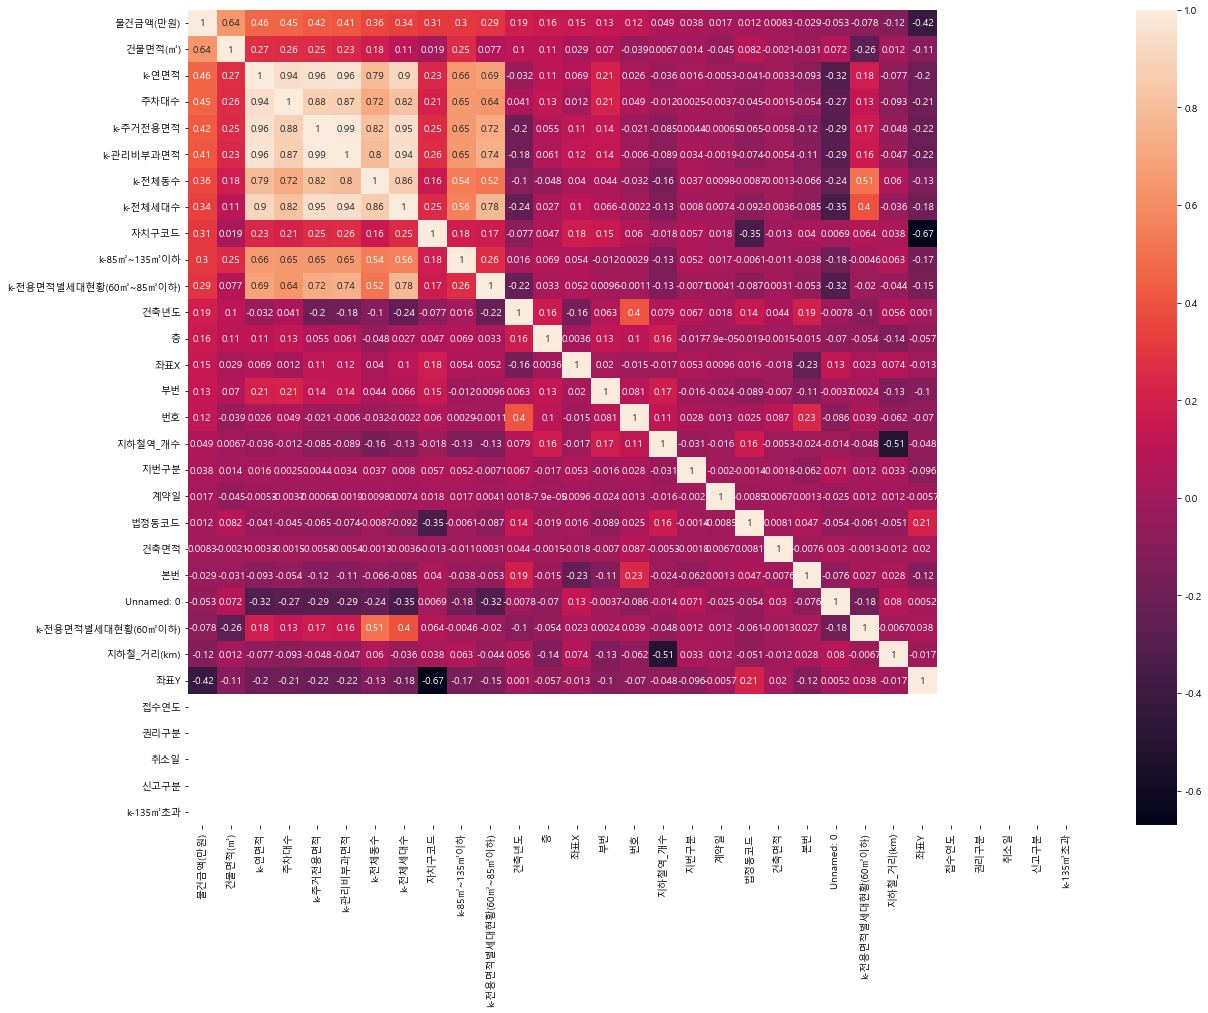

In [13]:
df2['물건금액(만원)'] = np.log(df2["물건금액(만원)"])
corr=df2.corr()
top_corr=df2[corr.nlargest(40,'물건금액(만원)')['물건금액(만원)'].index].corr()
figure, ax1 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(20,15)
sns.heatmap(top_corr, annot=True, ax=ax1)

<AxesSubplot:xlabel='지하철_거리(km)', ylabel='물건금액(만원)'>

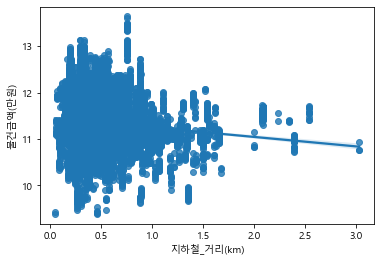

In [14]:
sns.regplot((df2['지하철_거리(km)']),df2['물건금액(만원)'])

히트맵의 계수와 residual plot에서 이를 활요하기 힘들다고 판단

학교 위치 추가

In [16]:
seoul_school = pd.read_csv("전국초중등학교위치표준데이터.csv", encoding  = "cp949")

seoul_school = seoul_school[(seoul_school.소재지지번주소.str.split(' ').str[0] == '서울특별시')]
seoul_school = seoul_school[["학교명", "학교급구분","위도", "경도"]]
seoul_el_school = seoul_school[(seoul_school["학교급구분"] == '초등학교')]
seoul_md_school = seoul_school[(seoul_school["학교급구분"] == '중학교')]
seoul_hi_school = seoul_school[(seoul_school["학교급구분"] == '고등학교')]
df_tg3 = df_tg2[["좌표X", "좌표Y"]]
df_tg3["초등학교_거리"] = np.nan
df_tg3["중학교_거리"] = np.nan
df_tg3["고등학교_거리"] = np.nan

dis = []
for index, i in df_tg3.iterrows():
    dis.clear()
    par_loc = (i["좌표Y"], i["좌표X"])
    for index, j in seoul_el_school.iterrows():
        sub_cor = (j["위도"], j["경도"])
        a = haversine(par_loc, sub_cor, unit = 'km')
        dis.append(a)
        i["초등학교_거리"] = min(dis)

dis = []
for index, i in df_tg3.iterrows():
    dis.clear()
    par_loc = (i["좌표Y"], i["좌표X"])
    for index, j in seoul_md_school.iterrows():
        sub_cor = (j["위도"], j["경도"])
        a = haversine(par_loc, sub_cor, unit = 'km')
        dis.append(a)
        i["중학교_거리"] = min(dis)

        
dis = []
for index, i in df_tg3.iterrows():
    dis.clear()
    par_loc = (i["좌표Y"], i["좌표X"])
    for index, j in seoul_hi_school.iterrows():
        sub_cor = (j["위도"], j["경도"])
        a = haversine(par_loc, sub_cor, unit = 'km')
        dis.append(a)
        i["고등학교_거리"] = min(dis)

df2 = pd.merge(df, df_tg3, left_on=["좌표X","좌표Y"] , right_on=["좌표X","좌표Y"])

<AxesSubplot:>

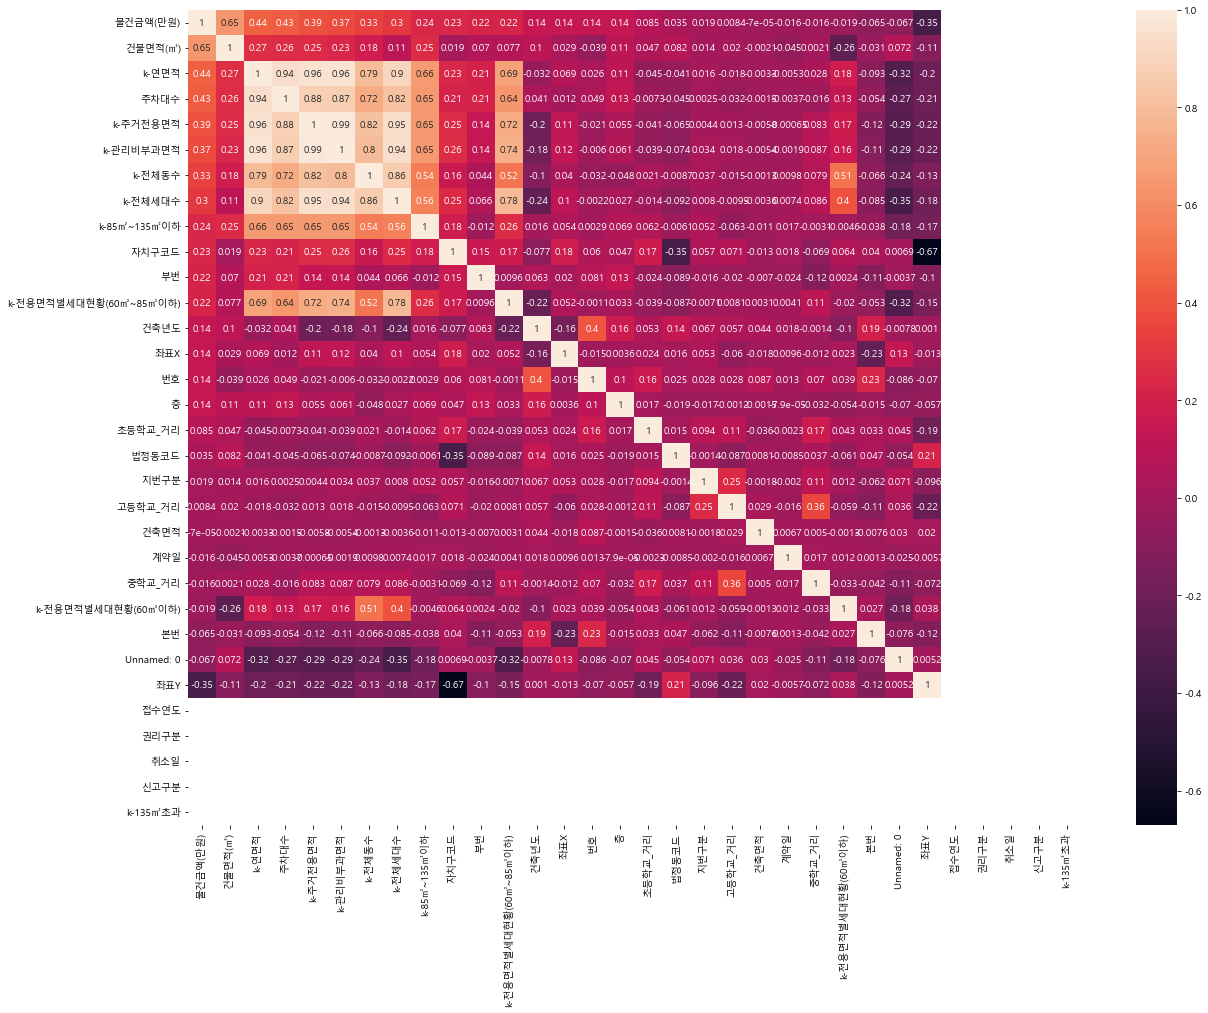

In [17]:
corr=df2.corr()
top_corr=df2[corr.nlargest(40,'물건금액(만원)')['물건금액(만원)'].index].corr()
figure, ax1 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(20,15)
sns.heatmap(top_corr, annot=True, ax=ax1)

도서관 정보 추가

In [18]:
seoul_lib = pd.read_csv("서울시 공공도서관 현황정보.csv", encoding = 'cp949')

seoul_lib = seoul_lib[["도서관명", "위도", "경도"]]
df_tg4 = df_tg2[["좌표X", "좌표Y"]]
df_tg4["도서관_거리"] = np.nan
df_tg4["도서관_개수"] = np.nan

dis = []
for index, i in df_tg4.iterrows():
    dis.clear()
    b = 0
    par_loc = (i["좌표Y"], i["좌표X"])
    for index, j in seoul_lib .iterrows():
        sub_cor = (j["위도"], j["경도"])
        a = haversine(par_loc, sub_cor, unit = 'km')
        dis.append(a)
    for k in dis:
        if k<=1:
            b = b+1
        i["도서관_거리"] = min(dis)
        i["도서관_개수"] = b
        
df2 = pd.merge(df, df_tg4, left_on=["좌표X","좌표Y"] , right_on=["좌표X","좌표Y"])

<AxesSubplot:>

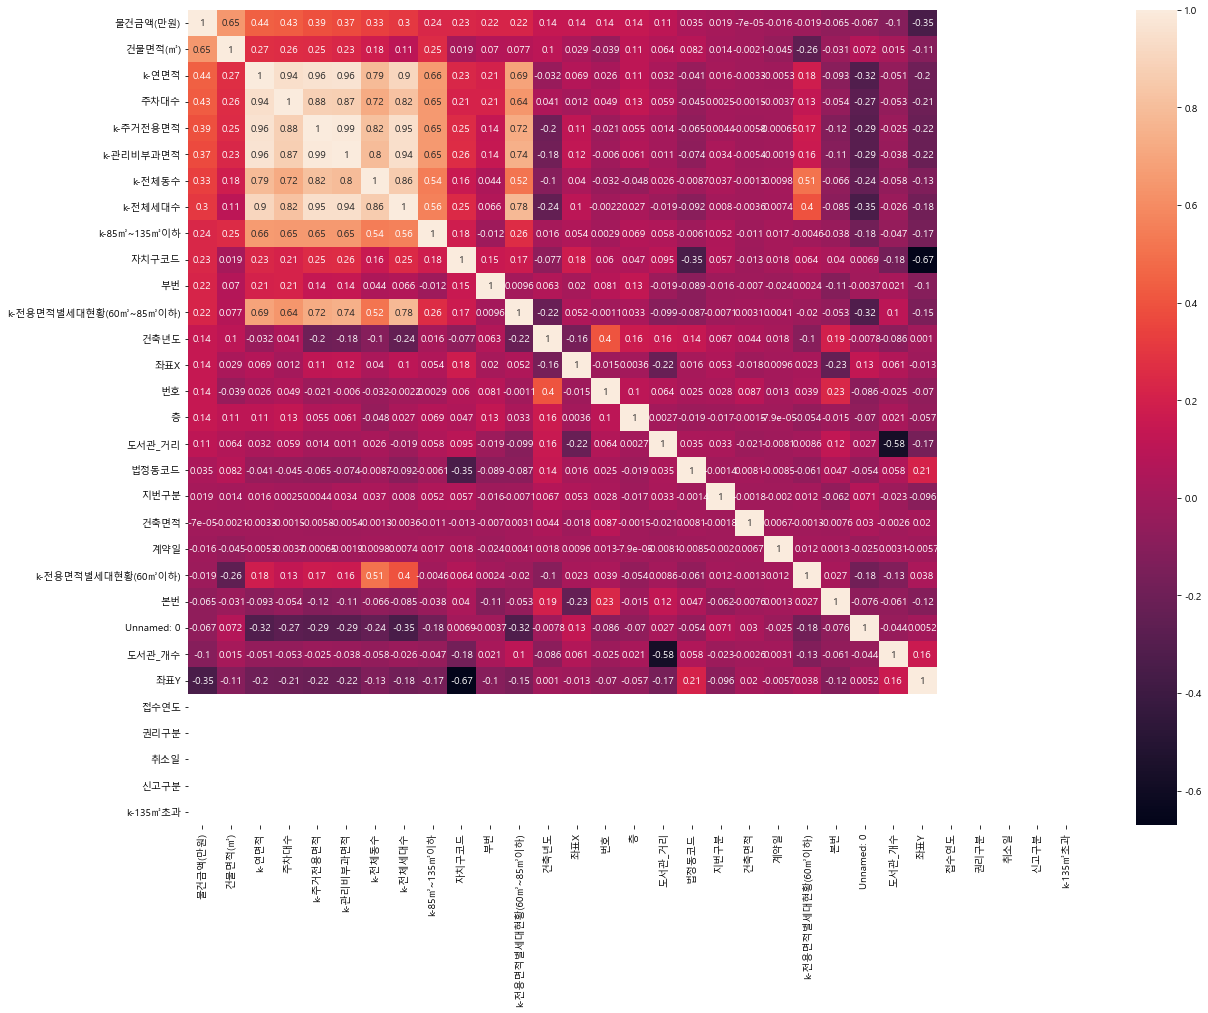

In [19]:
corr=df2.corr()
top_corr=df2[corr.nlargest(40,'물건금액(만원)')['물건금액(만원)'].index].corr()
figure, ax1 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(20,15)
sns.heatmap(top_corr, annot=True, ax=ax1)

공원정보 추가

In [20]:
seoul_park = pd.read_csv("서울시 주요 공원현황.csv", encoding = 'cp949')

seoul_park = seoul_park[["공원명", "X좌표(WGS84)", "Y좌표(WGS84)"]]

df_tg5 = df_tg2[["좌표X", "좌표Y"]]

df_tg5["공원_거리"] = np.nan
df_tg5["공원_개수"] = np.nan

dis = []
for index, i in df_tg5.iterrows():
    dis.clear()
    b = 0
    par_loc = (i["좌표Y"], i["좌표X"])
    for index, j in seoul_park .iterrows():
        sub_cor = (j["Y좌표(WGS84)"], j["X좌표(WGS84)"])
        a = haversine(par_loc, sub_cor, unit = 'km')
        dis.append(a)
    for k in dis:
        if k<=1:
            b = b+1
        i["공원_거리"] = min(dis)
        i["공원_개수"] = b

        
df2 = pd.merge(df, df_tg5, left_on=["좌표X","좌표Y"] , right_on=["좌표X","좌표Y"])

<AxesSubplot:>

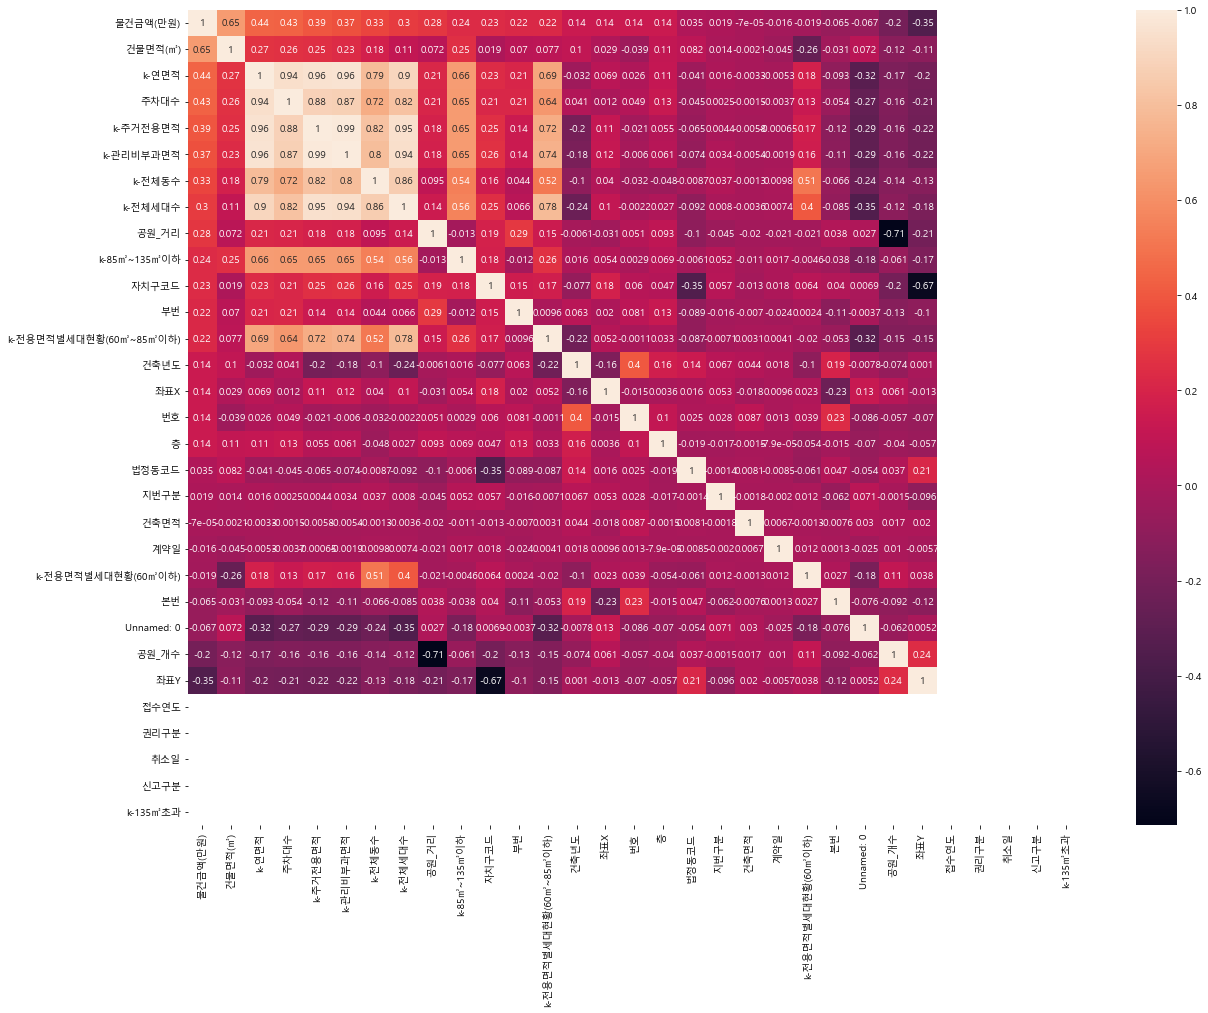

In [21]:
corr=df2.corr()
top_corr=df2[corr.nlargest(40,'물건금액(만원)')['물건금액(만원)'].index].corr()
figure, ax1 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(20,15)
sns.heatmap(top_corr, annot=True, ax=ax1)

# 한계점(하이퍼 파라미터)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
#from xgboost import XGBClassifier, plot_importance as xg_importance
#from lightgbm import LGBMClassifier, plot_importance as lgb_importance
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
plt.rcParams["axes.unicode_minus"] = False
path = "C:/Windows/Fonts/H2GTRM.TTF"
font_name = font_manager.FontProperties(fname=path).get_name()
rc("font", family=font_name)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
plt.rcParams["axes.unicode_minus"] = False
path = "C:/Windows/Fonts/H2GTRM.TTF"
font_name = font_manager.FontProperties(fname=path).get_name()
rc("font", family=font_name)

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score
from time import time

from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import AdaBoostRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

from time import time
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score
from time import time
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from itertools import product
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import math
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

## 원핫인코딩 후 모델링

In [ ]:
data = pd.read_csv("전처리 수치형 데이터.csv", encoding='cp949')
data_sel = data[['물건금액(만원)','건물면적(㎡)','k-연면적','층','건축년도','자치구명','법정동명',
           '건물용도','k-세대타입(분양형태)','k-복도유형','k-난방방식','k-단지분류(아파트,주상복합등등)']]

data_sel.loc[data_sel['k-단지분류(아파트,주상복합등등)']=='도시형 생활주택(주상복합)', '건물용도']='도시형 생활주택(주상복합)'

data_gu = pd.read_csv("구별 모든 정보.csv")
gu = data_gu[['구별','구별인구밀도']]
gu.columns = ['자치구명','구별인구밀도']
df = pd.merge(data_sel, gu, on='자치구명')

df['물건금액(만원)'] = np.log(df['물건금액(만원)'])
df['k-연면적비'] = np.log(df['k-연면적']/df['구별인구밀도'])
df['건물면적비'] = np.log(df['건물면적(㎡)']/df['구별인구밀도'])

#df['k-연면적비'] = df['k-연면적']/df['구별인구밀도']
#df['건물면적비'] = df['건물면적(㎡)']/df['구별인구밀도']



df = df.drop(['k-단지분류(아파트,주상복합등등)','구별인구밀도'], axis=1)

df_dummy = pd.get_dummies(df)
df_dummy = df_dummy.dropna()

X = df_dummy.drop('물건금액(만원)', axis=1)
y = df_dummy[['물건금액(만원)']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train = std_scaler.transform(X_train)
X_test = std_scaler.transform(X_test)

## XGB

In [ ]:
model = XGBRegressor()

parameters = {
    'n_estimators' : [100, 200],
    'learning_rate' : [0.01,0.05,0.1,0.15],
    'max_depth' : [26,28,30,32,34],
    'gamma' : [0,1,2,3],
    'colsample_bytree' : [0.8,0.9]}

grid_rf = GridSearchCV(model, 
                          param_grid=parameters,
                          scoring='r2',
                          n_jobs=-1,
                          refit=True,
                          cv=5,
                          verbose=1,
                          return_train_score=True
                          )

grid_rf.fit(X_train, y_train)

print("best_score:", grid_rf.best_score_)
print("best_parameters:", grid_rf.best_params_)

## RandomForest

In [ ]:
model = RandomForestRegressor(random_state = 42)
parameters = {'n_estimators':[120, 130, 135, 140],
              'max_depth':[32,33,34,35,36,37,38],
              'min_samples_leaf':[1,2],
              'min_samples_split':[4,5,6]}

grid_rf = GridSearchCV(model, 
                          param_grid=parameters,
                          scoring='r2',
                          n_jobs=-1,
                          refit=True,
                          cv=3,
                          verbose=1,
                          return_train_score=True
                          )

grid_rf.fit(X_train, y_train)


print("best_score:", grid_rf.best_score_)
print("best_parameters:", grid_rf.best_params_)

# catboost

In [ ]:
model = CatBoostRegressor(random_state = 42)
parameters = {'depth'         : [14,15,16],
                 'learning_rate' : [0.07, 0.08, 0.09, 0.1],
                  'iterations'    : [180, 200, 210]
                 }

grid_rf = GridSearchCV(model, 
                          param_grid=parameters,
                          scoring='r2',
                          n_jobs=-1,
                          refit=True,
                          cv=3,
                          verbose=1,
                          return_train_score=True
                          )

grid_rf.fit(X_train, y_train)

print("best_score:", grid_rf.best_score_)
print("best_parameters:", grid_rf.best_params_)

## 레이블 인코딩

In [ ]:
data = pd.read_csv("전처리 수치형 데이터.csv", encoding='cp949')
data_sel = data[['물건금액(만원)','건물면적(㎡)','k-연면적','층','건축년도','자치구명','법정동명',
           '건물용도','k-세대타입(분양형태)','k-복도유형','k-난방방식','세대전기계약방법','k-단지분류(아파트,주상복합등등)']]

data_sel.loc[data_sel['k-단지분류(아파트,주상복합등등)']=='도시형 생활주택(주상복합)', '건물용도']='도시형 생활주택(주상복합)'

data_gu = pd.read_csv("구별 모든 정보.csv")
gu = data_gu[['구별','구별인구밀도']]
gu.columns = ['자치구명','구별인구밀도']
df = pd.merge(data_sel, gu, on='자치구명')

df['물건금액(만원)'] = np.log(df['물건금액(만원)'])
df['k-연면적비'] = np.log(df['k-연면적']/df['구별인구밀도'])
df['건물면적비'] = np.log(df['건물면적(㎡)']/df['구별인구밀도'])


#df['k-연면적비'] = df['k-연면적']/df['구별인구밀도']
#df['건물면적비'] = df['건물면적(㎡)']/df['구별인구밀도']


df = df.drop(['k-단지분류(아파트,주상복합등등)','k-연면적','건물면적(㎡)','구별인구밀도'], axis=1)

label_obj_list = ['자치구명','법정동명','층','건축년도','건물용도','k-세대타입(분양형태)','k-복도유형','k-난방방식','세대전기계약방법']
df_sel = df.dropna()
       
from sklearn.preprocessing import LabelEncoder

for obj in label_obj_list:
    encoder = LabelEncoder()
    encoder.fit(list(df_sel[obj].values))
    df_sel[obj] = encoder.transform(list(df_sel[obj].values))
    
X = df_sel.drop('물건금액(만원)', axis=1)
y = df_sel[['물건금액(만원)']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train = std_scaler.transform(X_train)
X_test = std_scaler.transform(X_test)

## XGBoost

In [ ]:
model = XGBRegressor()

parameters = {
    'n_estimators' : [100, 200],
    'learning_rate' : [0.01,0.05,0.1,0.15],
    'max_depth' : [56,7,8, 9],
    'gamma' : [0,1,2,3],
    'colsample_bytree' : [0.8,0.9]}

grid_rf = GridSearchCV(model, 
                          param_grid=parameters,
                          scoring='r2',
                          n_jobs=-1,
                          refit=True,
                          cv=5,
                          verbose=1,
                          return_train_score=True
                          )

grid_rf.fit(X_train, y_train)

print("best_score:", grid_rf.best_score_)
print("best_parameters:", grid_rf.best_params_)

## Decision tree

In [ ]:
model = DecisionTreeRegressor()
parameters = {'max_depth':[28, 29, 30, 31, 32, 33, 34, 35, 37, 38],
              'min_samples_leaf':[1,2,3,5],
              'min_samples_split':[1,2,3,5,6,7,8, 9, 10]}

grid_rf = GridSearchCV(model, 
                          param_grid=parameters,
                          scoring='r2',
                          n_jobs=-1,
                          refit=True,
                          cv=5,
                          verbose=1,
                          return_train_score=True
                          )

grid_rf.fit(X_train, y_train)
print("best_score:", grid_rf.best_score_)
print("best_parameters:", grid_rf.best_params_)

## Random Forest

In [ ]:
model = RandomForestRegressor(random_state = 42)
parameters = {'n_estimators':[120, 130, 135, 140],
              'max_depth':[32,33,34,35,36,37,38],
              'min_samples_leaf':[1,2],
              'min_samples_split':[4,5,6]}

grid_rf = GridSearchCV(model, 
                          param_grid=parameters,
                          scoring='r2',
                          n_jobs=-1,
                          refit=True,
                          cv=3,
                          verbose=1,
                          return_train_score=True
                          )

grid_rf.fit(X_train, y_train)


print("best_score:", grid_rf.best_score_)
print("best_parameters:", grid_rf.best_params_)

## CatBoost

In [ ]:
model = CatBoostRegressor()
parameters = {'depth'         : [6,8,9,10,12,14],
                 'learning_rate' : [0.01,0.02,0.03,0.04],
                  'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]
                 }

grid_rf = GridSearchCV(model, 
                          param_grid=parameters,
                          scoring='r2',
                          n_jobs=-1,
                          refit=True,
                          cv=5,
                          verbose=1,
                          return_train_score=True
                          )

grid_rf.fit(X_train, y_train)

print("best_score:", grid_rf.best_score_)
print("best_parameters:", grid_rf.best_params_)